<a href="https://www.kaggle.com/code/rubanzasilva/eda-gradient-boosting-neural-nets-s04e11?scriptVersionId=209437599" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Exploring mental health - Introduction - Binary Classification.

Here our goal is to use data from a mental health survey to explore factors that may cause individuals to experience depression and use this to classify whether an individual is at risk of depression or not.

The data for this particular competition is synthentically generated from the Depression Survey/Dataset for Analysis linked in the data section of the competition.
The original dataset was collected from a survey carried out among adults aimed and understanding depression risk factors based on inputs provided by particpants in the survey.

Among the dataset notes is

> A number of data artifacts have been left in the synthetic dataset.

which means there are possibly some notable differences between the original dataset and our synthentically generated dataset hence we shall explore both datasets and their differences below.

The target variable is either "0" or "1" hence our goal here will be to predict the target class.

Exploring this dataset can help us understand and provide key insights into how everyday factors contribute to our mental health.

V1
In this notebook, i shall be trying out the following

* Exploring the data
* Neural Networks
* Gradient Boosting
* AutoML
* Ensembles

## Data & Library Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv
/kaggle/input/playground-series-s4e11/sample_submission.csv
/kaggle/input/playground-series-s4e11/train.csv
/kaggle/input/playground-series-s4e11/test.csv


In [2]:
%%time
%pip install catboost
%pip install optuna
#%pip install optuna_distributed
#%pip install openfe
%pip install seaborn
%pip install xgboost
%pip install lightgbm
%pip install fastkaggle
#%pip install h2o
%pip install -Uqq fastbook
#%pip install polars
%pip install -q -U autogluon.tabular
%pip install autogluon
%pip install --upgrade pip
%pip install tqdm
#%pip install wandb
#%pip install sweetviz

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [3006 lines of output]
      Ignoring numpy: markers 'python_version == "3.6" and platform_system != "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_system != "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.6" and platform_system == "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_system == "AIX"' don't match you

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from tqdm import tqdm

#import fastbook
#fastbook.setup_book()
#from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from tqdm import tqdm
from ipywidgets import interact

from fastai.imports import *
np.set_printoptions(linewidth=130)


from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier,StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,StratifiedKFold, cross_val_score,train_test_split,GridSearchCV


from pathlib import Path
import os

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv


import warnings


#from openfe import OpenFE, transform
#from autogluon.tabular import TabularDataset, TabularPredictor

#import h2o
#from h2o.automl import H2OAutoML

import gc

import optuna
from optuna.samplers import TPESampler

import pickle
from joblib import dump, load
#import sweetviz as sv
#from IPython.display import FileLink

#import h2o
#from h2o.automl import H2OAutoML

In [4]:
#torch.manual_seed(42)

In [5]:
path = Path('/kaggle/input/playground-series-s4e11/')
path

Path('/kaggle/input/playground-series-s4e11')

In [6]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv')
original_df = pd.read_csv('/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv')

In [7]:
train_df.shape,original_df.shape

((140700, 19), (2556, 19))

In [8]:
#train_df = pd.concat([train_df, original_df], ignore_index=True)

# Exploratory Data Analysis

In [9]:
train_df.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [10]:
original_df.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Pooja,Female,37,Ghaziabad,Working Professional,Teacher,NaN,2.0,NaN,NaN,4.0,7-8 hours,Moderate,MA,No,6,2,No,No
1,Reyansh,Male,60,Kalyan,Working Professional,Financial Analyst,NaN,4.0,NaN,NaN,3.0,5-6 hours,Unhealthy,B.Com,Yes,0,4,Yes,No
2,Manvi,Female,42,Bhopal,Working Professional,Teacher,NaN,2.0,NaN,NaN,3.0,5-6 hours,Moderate,M.Com,No,0,2,No,No
3,Isha,Female,44,Thane,Working Professional,Teacher,NaN,3.0,NaN,NaN,5.0,7-8 hours,Healthy,MD,Yes,1,2,Yes,No
4,Aarav,Male,48,Indore,Working Professional,UX/UI Designer,NaN,4.0,NaN,NaN,3.0,7-8 hours,Moderate,BE,Yes,6,5,Yes,No


In [11]:
original_df['Depression'] = original_df['Depression'].map({"Yes": 1, "No": 0})

In [12]:
original_df.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Pooja,Female,37,Ghaziabad,Working Professional,Teacher,NaN,2.0,NaN,NaN,4.0,7-8 hours,Moderate,MA,No,6,2,No,0
1,Reyansh,Male,60,Kalyan,Working Professional,Financial Analyst,NaN,4.0,NaN,NaN,3.0,5-6 hours,Unhealthy,B.Com,Yes,0,4,Yes,0
2,Manvi,Female,42,Bhopal,Working Professional,Teacher,NaN,2.0,NaN,NaN,3.0,5-6 hours,Moderate,M.Com,No,0,2,No,0
3,Isha,Female,44,Thane,Working Professional,Teacher,NaN,3.0,NaN,NaN,5.0,7-8 hours,Healthy,MD,Yes,1,2,Yes,0
4,Aarav,Male,48,Indore,Working Professional,UX/UI Designer,NaN,4.0,NaN,NaN,3.0,7-8 hours,Moderate,BE,Yes,6,5,Yes,0


In [13]:
train_df.shape

(140700, 19)

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140700 entries, 0 to 140699
Data columns (total 19 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Name                                   140700 non-null  object 
 1   Gender                                 140700 non-null  object 
 2   Age                                    140700 non-null  float64
 3   City                                   140700 non-null  object 
 4   Working Professional or Student        140700 non-null  object 
 5   Profession                             104070 non-null  object 
 6   Academic Pressure                      27897 non-null   float64
 7   Work Pressure                          112782 non-null  float64
 8   CGPA                                   27898 non-null   float64
 9   Study Satisfaction                     27897 non-null   float64
 10  Job Satisfaction                       112790 non-null  float

In [15]:
train_df.columns

Index(['Name', 'Gender', 'Age', 'City', 'Working Professional or Student',
       'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness', 'Depression'],
      dtype='object')

# Missing Value Check

In [16]:
missing_values_count = train_df.isnull().sum()
sorted_missing_values = missing_values_count.sort_values(ascending=False)
print(sorted_missing_values)

Study Satisfaction                       112803
Academic Pressure                        112803
CGPA                                     112802
Profession                                36630
Work Pressure                             27918
Job Satisfaction                          27910
Dietary Habits                                4
Financial Stress                              4
Degree                                        2
Family History of Mental Illness              0
Work/Study Hours                              0
Have you ever had suicidal thoughts ?         0
Name                                          0
Sleep Duration                                0
Gender                                        0
Working Professional or Student               0
City                                          0
Age                                           0
Depression                                    0
dtype: int64


In [17]:
#Missing values returned as percentages.
missing_percentages = train_df.isnull().mean() * 100
sorted_missing_percentages = missing_percentages.sort_values(ascending=False)
print(sorted_missing_percentages)

Study Satisfaction                       80.172708
Academic Pressure                        80.172708
CGPA                                     80.171997
Profession                               26.034115
Work Pressure                            19.842217
Job Satisfaction                         19.836532
Dietary Habits                            0.002843
Financial Stress                          0.002843
Degree                                    0.001421
Family History of Mental Illness          0.000000
Work/Study Hours                          0.000000
Have you ever had suicidal thoughts ?     0.000000
Name                                      0.000000
Sleep Duration                            0.000000
Gender                                    0.000000
Working Professional or Student           0.000000
City                                      0.000000
Age                                       0.000000
Depression                                0.000000
dtype: float64


## Summary Statistics

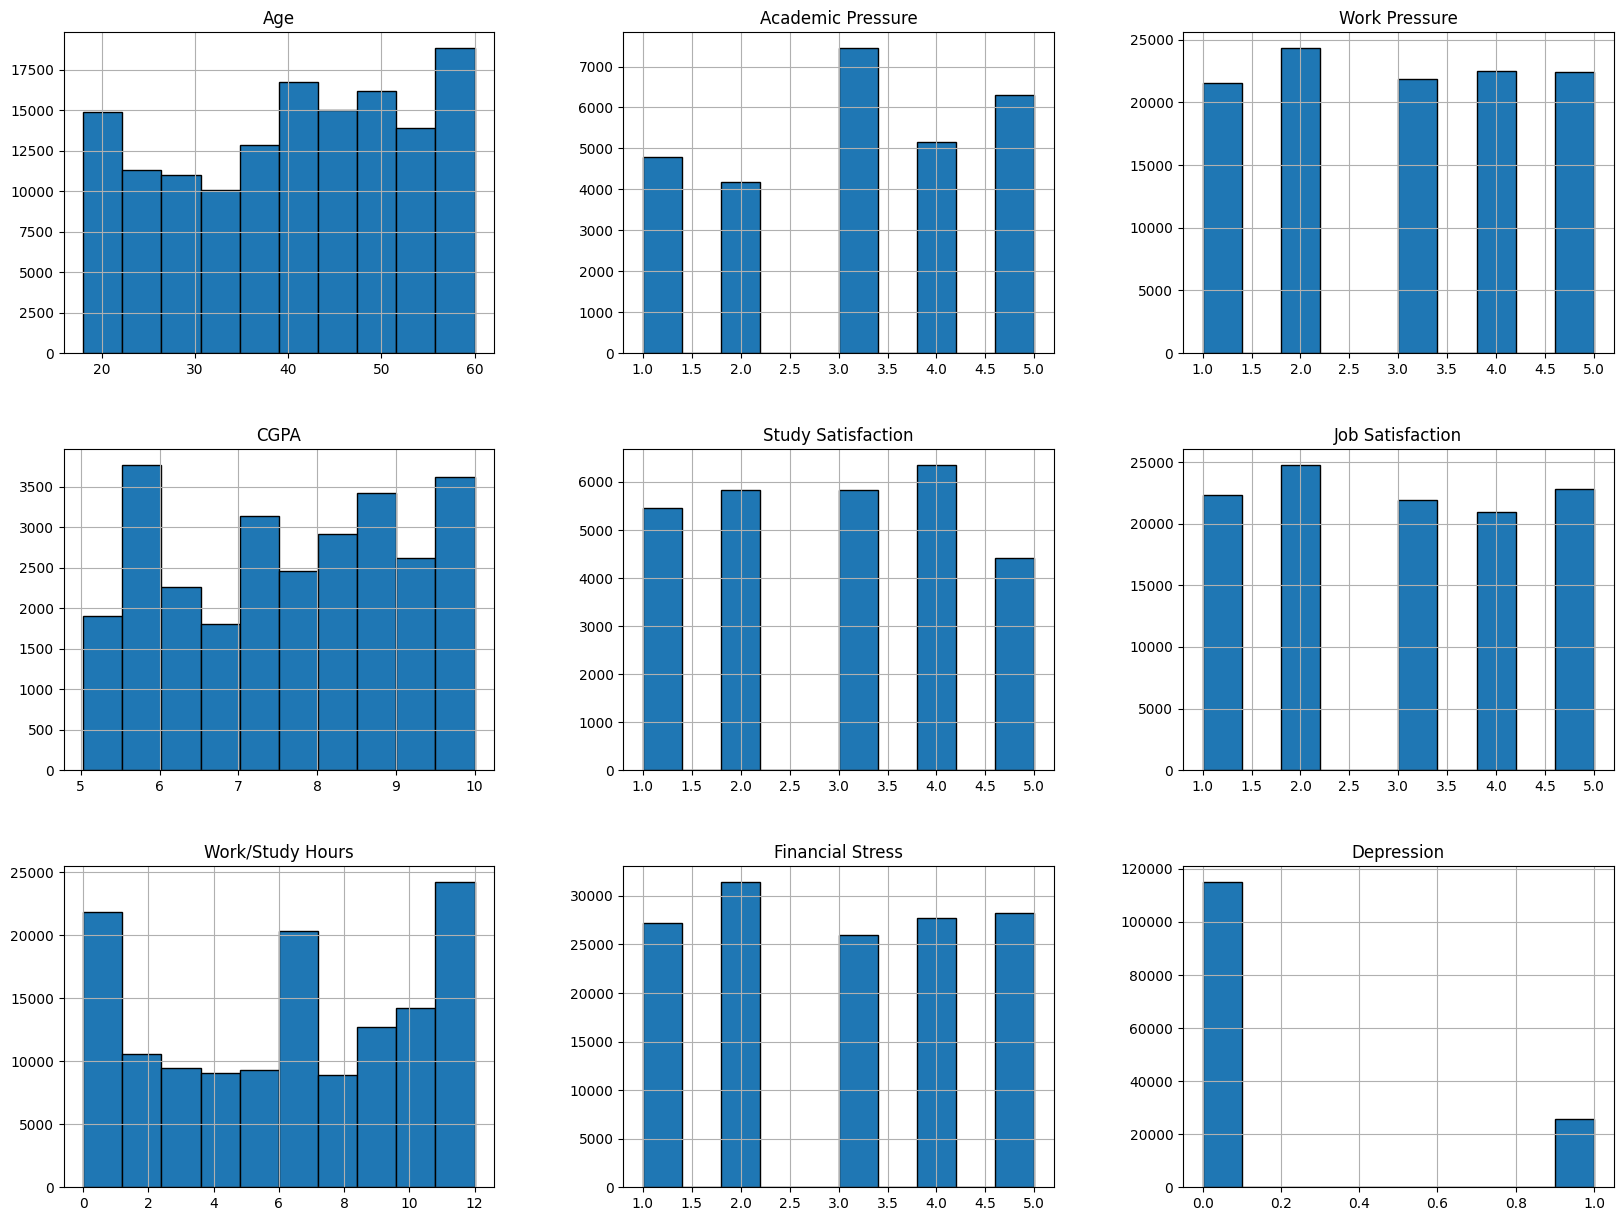

In [18]:
train_df.hist(figsize=(20,15),edgecolor='black');

In [19]:
#train_df.info()

In [20]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,140700.0,40.388621,12.384099,18.00,29.00,42.00,51.00,60.0
Academic Pressure,27897.0,3.142273,1.380457,1.00,2.00,3.00,4.00,5.0
Work Pressure,112782.0,2.998998,1.405771,1.00,2.00,3.00,4.00,5.0
CGPA,27898.0,7.658636,1.464466,5.03,6.29,7.77,8.92,10.0
Study Satisfaction,27897.0,2.944940,1.360197,1.00,2.00,3.00,4.00,5.0
Job Satisfaction,112790.0,2.974404,1.416078,1.00,2.00,3.00,4.00,5.0
Work/Study Hours,140700.0,6.252679,3.853615,0.00,3.00,6.00,10.00,12.0
Financial Stress,140696.0,2.988983,1.413633,1.00,2.00,3.00,4.00,5.0
Depression,140700.0,0.181713,0.385609,0.00,0.00,0.00,0.00,1.0


### Target Variable

In [21]:
#train_df['Depression'].hist(figsize=(6,4));

In [22]:
#def cat_count_plot_dist(data,column,title=None,figsize=(15,10)):

In [23]:
def cat_plot_count_dist(data, column, title=None, figsize=(15,10)):
    plt.figure(figsize=figsize)
    ax = sns.countplot(x=column, data=data)
    
    # Set title (use column name if title not provided)
    title = title or f'Distribution by {column}'
    plt.title(title, fontsize=16)
    
    # Set labels
    plt.xlabel(column, fontsize=16)
    plt.ylabel('Count', fontsize=16)
    
    # Set tick sizes
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Add value labels on bars
    for i in ax.containers:
        ax.bar_label(i, fontsize=14, padding=10)
        
    plt.tight_layout()
    plt.show()

In [24]:
def plot_pie_distribution(data, column, explode=None, figsize=(6,6), title=None):
   # Get value counts
   counts = data[column].value_counts()
   
   # Set default explode if not provided 
   if explode is None:
       explode = tuple([0] * len(counts))
   
   # Set default title if not provided
   title = title or f'Distribution of {column}'
   
   plt.figure(figsize=figsize)
   plt.pie(counts.values, labels=counts.index,
           explode=explode, autopct='%1.1f%%', startangle=90)
   plt.axis('equal')
   plt.title(title, fontsize=16)
   plt.show()


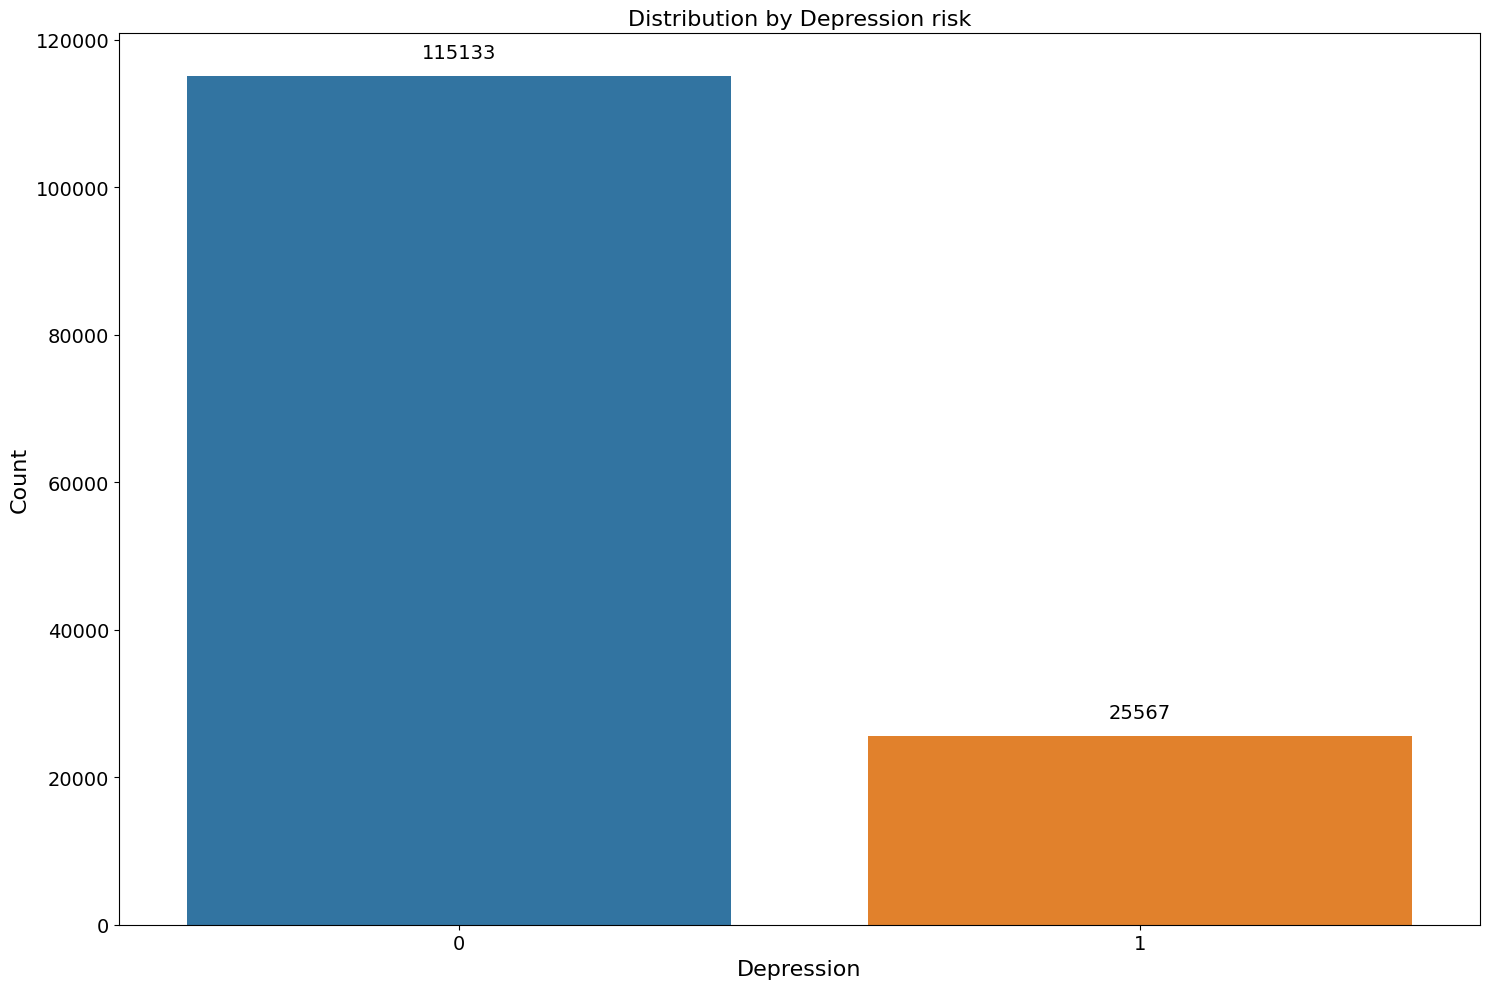

In [25]:
#cat_plot_count_dist(train_df, 'Depression', figsize=(12,8))
cat_plot_count_dist(train_df, 'Depression', 'Distribution by Depression risk')

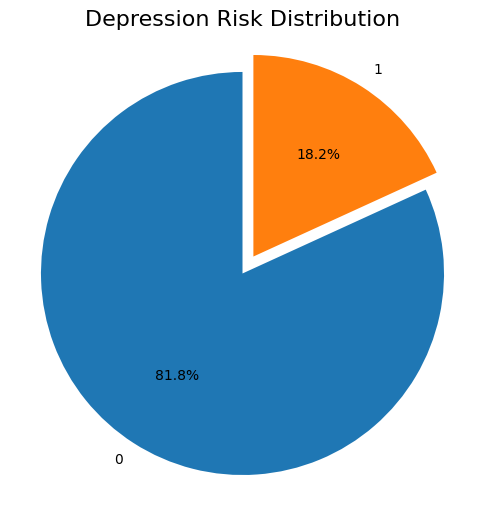

In [26]:
plot_pie_distribution(train_df, 'Depression', 
                    explode=(0,0.1), 
                    title='Depression Risk Distribution')

We can see from above that the dataset is imbalanced.

### Univariate Analysis

Let us take a look at the categorical variables shown by adding include=[object] below

In [27]:
train_df.describe(include=[object]).T

,count,unique,top,freq
Name,140700,422,Rohan,3178
Gender,140700,2,Male,77464
City,140700,98,Kalyan,6591
Working Professional or Student,140700,2,Working Professional,112799
Profession,104070,64,Teacher,24906
Sleep Duration,140700,36,Less than 5 hours,38784
Dietary Habits,140696,23,Moderate,49705
Degree,140698,115,Class 12,14729
Have you ever had suicidal thoughts ?,140700,2,No,71138
Family History of Mental Illness,140700,2,No,70758


#### Name

In [28]:
train_df['Name'].nunique()

422

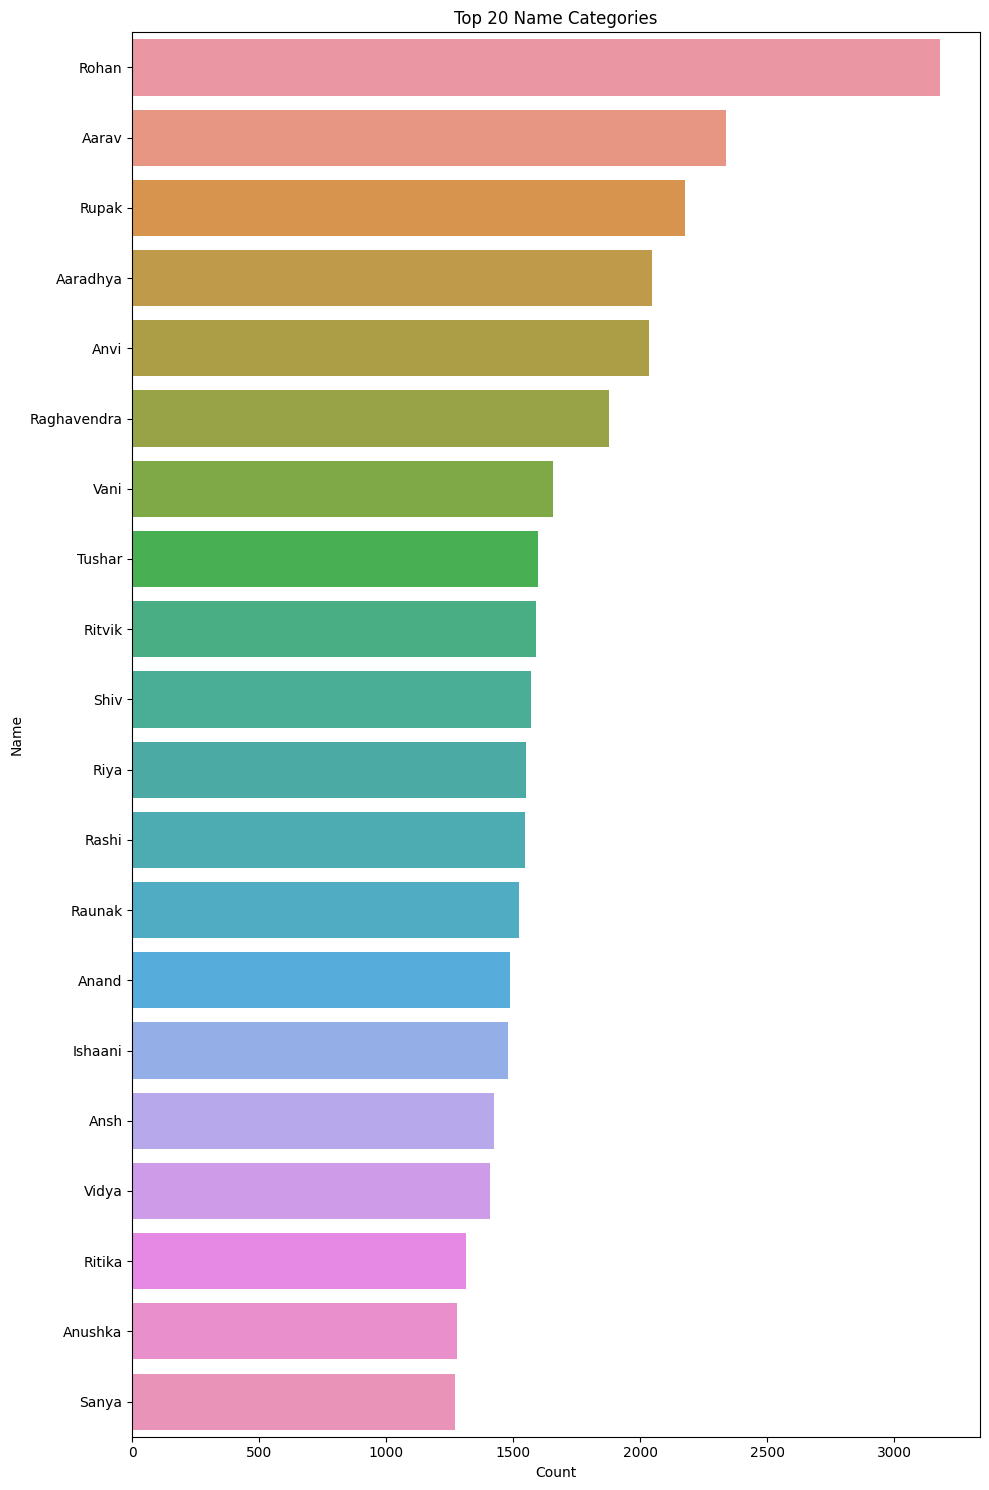

In [29]:
def plot_top_categories(data, column, top_n=20, figsize=(10,15)):
    # Get value counts and take top N
    top_values = data[column].value_counts().head(top_n)
    
    plt.figure(figsize=figsize)
    sns.barplot(x=top_values.values, y=top_values.index)
    plt.title(f'Top {top_n} {column} Categories')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()


plot_top_categories(train_df, 'Name', top_n=20)

It seems that Rohan in quite the popular name.

Personally i have a feeling name isnt a big influencing factor as you are named at before or at birth, but we can look at the model feature importance below for more conclusive evidence.

After taking a look at the feature importance for the various models below, it does seem to actually be an important variable. I wonder why name would be an important factor. I will try to look into this later on.

#### Gender

In [30]:
train_df['Gender'].unique(),train_df['Gender'].nunique()

(array(['Female', 'Male'], dtype=object), 2)

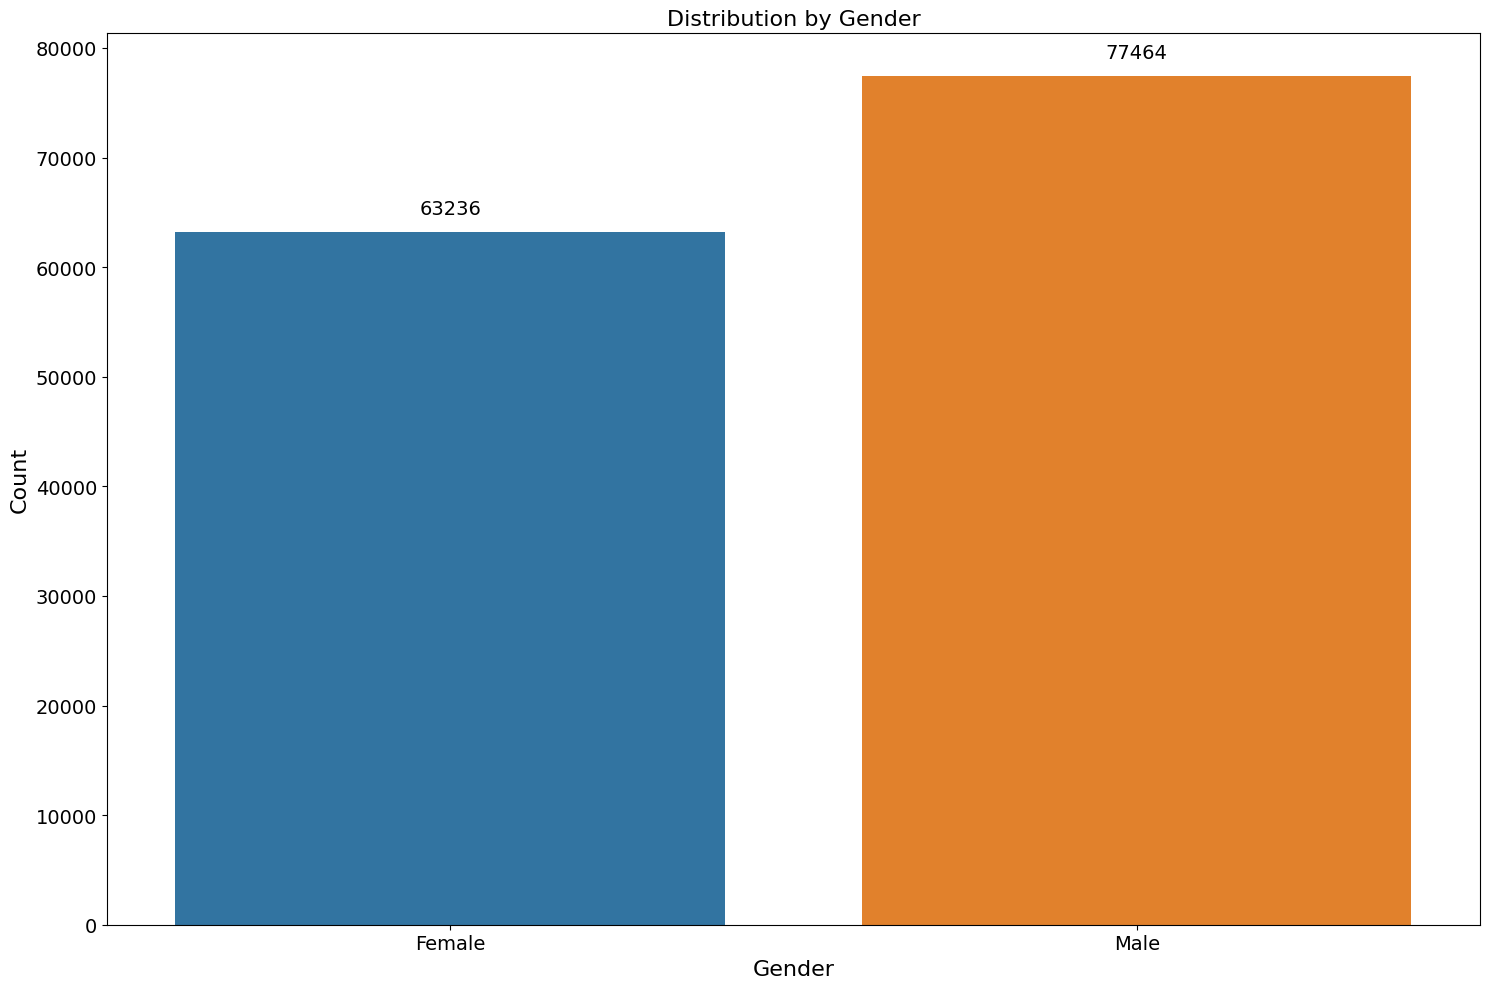

In [31]:
cat_plot_count_dist(train_df, 'Gender', 'Distribution by Gender')

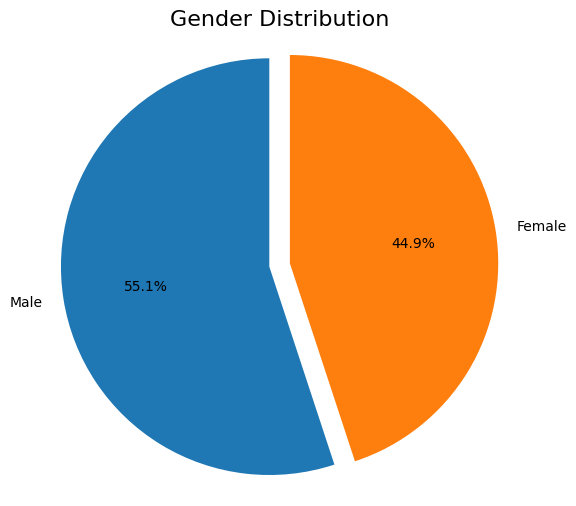

In [32]:
plot_pie_distribution(train_df, 'Gender', 
                    explode=(0,0.1), 
                    title='Gender Distribution')

The dataset has almost as many women as men potentially reducing the bias caused by class imbalance.

### FE Idea from public

In [33]:
#categories = {}
#clean_cols = ['City', 'Profession', 'SleepDuration', 'DietaryHabits', 'Degree']

# Get unique categories from original data
#for col in clean_cols:
    #categories[col] = list(original_df[col].unique())

# Function to transform the data
#def transform_data(df):
    #df = df.copy()
    
    # Replace non-unique categories with 'missing'
    #for col in clean_cols:
        #if col in df.columns:
            #df[col] = np.where(df[col].isin(categories[col]), df[col], "missing")
    
    # Add new combined features without fillna
    #df["Pressure"] = np.uiint8(df["WorkPressure"] + df['AcademicPressure'])
    #df["Satisfaction"] = np.uint8(df["StudySatisfaction"] + df['JobSatisfaction'])
    
    #return df

# Transform train and test data
#train_df = transform_data(train_df)
#test_df = transform_data(test_df)

In [34]:
train_df.shape,test_df.shape

((140700, 19), (93800, 18))

## Data Pre-processing with fast.ai



In [35]:
train_df.shape,original_df.shape

((140700, 19), (2556, 19))

In [36]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

I decided to put concat the original df and the train df after doing the split so that validation can be done on the competition dataset only.

In [37]:
train_df = pd.concat([train_df, original_df], ignore_index=True)
#train_df = pd.concat(objs=[train_df, original_df])

In [38]:
train_df.shape,original_df.shape

((143256, 19), (2556, 19))

In [39]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Depression')
#splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
#to = TabularPandas(train_df, procs=[Categorify,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Depression',
                   y_block=CategoryBlock(),
                   splits=splits)
dls = to.dataloaders(bs=64)
#dls = to.dataloaders(bs=1024)
test_dl = dls.test_dl(test_df)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

I will explain what is going on above

- First we define categorical and continous variables
I use the fastai cont_cat_split function to separate my dataset variables into categorical and continous variables based of the cardinality of my column values.

We take an argument max card whose default is 20.If the number of unique values is above 20 (max_card value) for a particular column, that column is considered continous and vice versa.

- Split into training and validation set
The RandomSplitter below separates the training set into a training and validation set based off the value of the argument valid_pct.

- Define a TabularPandas object.
Here we declare the continous and categorical columns, the dataset splitting strategy, preprocessing steps to apply to our datasets, the dependent variable which is what we are predicting and the type of problem we are optimizing for such as binary classification in this case.

- Create and define a dataloaders
This prepares our data for input into our neural network.Here we can define our batch size.

- Extract train and validation sets + their values.


In [40]:
cont_names,len(cont_names)

(['Age',
  'Academic Pressure',
  'Work Pressure',
  'CGPA',
  'Study Satisfaction',
  'Job Satisfaction',
  'Work/Study Hours',
  'Financial Stress'],
 8)

In [41]:
cat_names,len(cat_names)

(['Name',
  'Gender',
  'City',
  'Working Professional or Student',
  'Profession',
  'Sleep Duration',
  'Dietary Habits',
  'Degree',
  'Have you ever had suicidal thoughts ?',
  'Family History of Mental Illness',
  'Academic Pressure_na',
  'Work Pressure_na',
  'CGPA_na',
  'Study Satisfaction_na',
  'Job Satisfaction_na',
  'Financial Stress_na'],
 16)

In [42]:
train_df.shape,X_train.shape

((143256, 19), (112560, 24))

It seems the preprocessing steps from above result in new columns in my training data, X_train

# Models

In [43]:
xgb_params = {'seed':42}
lgbm_params = {'seed':42}
cat_params = {'random_seed':42}
rf_params = {'random_state':42}

In [44]:
catboost_params = {'iterations': 715,
 'learning_rate': 0.05009420761428966,
 'colsample_bylevel': 0.5859169200239407,
 'subsample': 0.7705184727295318,
 'min_data_in_leaf': 30,
 'depth': 7,
 'l2_leaf_reg': 0.004379496536587387,
 'random_strength': 0.4519161767798322}

## Cross Validation function

In [45]:
def cross_val_predict(model_class, model_params=None, n_splits=5, random_state=42):
    if model_params is None:
        model_params = {}
    """
    Perform cross-validation using the fixed dataset and return predictions and scores.
    
    Parameters:
    - model_class: the model class (e.g., xgb.XGBClassifier)
    - model_params: dictionary of model parameters
    - n_splits: number of CV folds
    - random_state: random seed for reproducibility
    
    Returns:
    - oof_predictions: out-of-fold predictions on training set
    - submission_predictions: predictions on test_dl.xs
    - mean_score: mean accuracy score across folds
    - fold_scores: list of scores for each fold
    """
    
    # Initialize stratified k-fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Initialize arrays to store results
    oof_predictions = np.zeros(len(X_train))  # Array for OOF predictions
    submission_predictions = np.zeros(len(test_dl.xs))  # Array for test predictions
    fold_scores = []
    
    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
        # Split data for current fold
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        # Initialize and train model on current fold
        model_fold = model_class(**model_params)
        model_fold.fit(X_fold_train, y_fold_train)
        
        # Get predictions
        y_pred_fold = model_fold.predict(X_fold_val)
        
        # Store OOF predictions
        oof_predictions[val_index] = y_pred_fold
        
        # Get and accumulate test predictions
        submission_predictions += model_fold.predict(test_dl.xs) / n_splits
        
        # Calculate and store score
        cv_score = accuracy_score(y_fold_val, y_pred_fold)
        fold_scores.append(cv_score)
        
        print(f"Fold {fold} AUC: {cv_score:.6f}")
    
    # Calculate mean score
    mean_score = np.mean(fold_scores)
    print(f"\nMean AUC: {mean_score:.6f}")
    
    return oof_predictions, submission_predictions, mean_score, fold_scores

# Usage example:
#oof_preds, submission_preds, mean_score, fold_scores = cross_val_predict(
    #model_class=xgb.XGBClassifier
#)

# Create submission file
#submission_df = pd.DataFrame({
    #'id': test_df.index,  # adjust if you have different id column
    #'Depression': submission_preds
#})
#submission_df.to_csv('submission.csv', index=False)

# You can also analyze OOF predictions
#print("\nOOF Predictions Score:", accuracy_score(y_train, oof_preds))

## Deep learning - Neural Networks

In [46]:
learn = tabular_learner(dls, metrics=accuracy)

/opt/conda/lib/python3.10/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.0020892962347716093)

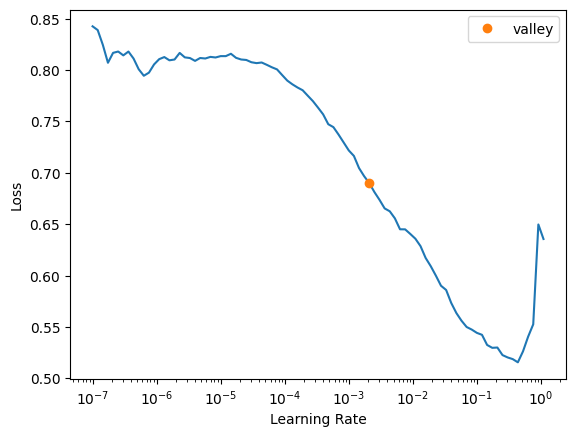

In [47]:
learn.lr_find()

In [48]:
learn.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.167419,0.163388,0.936532,00:24
1,0.165310,0.151474,0.939197,00:24
2,0.148936,0.151740,0.938273,00:24
3,0.137382,0.154855,0.937349,00:24
4,0.152531,0.155254,0.937882,00:24
5,0.137328,0.156830,0.937669,00:24
6,0.133504,0.159641,0.937527,00:24
7,0.135109,0.160382,0.936354,00:24
8,0.131446,0.160799,0.936141,00:25
9,0.128867,0.160705,0.936247,00:24


In [49]:
dl = test_dl

In [50]:
learn.save('nn_model_mental_health_v1')

Path('models/nn_model_mental_health_v1.pth')

In [51]:
#learn.load('nn_model_loan_approval_v1')  

In [52]:
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)
nn_preds_proba = (a_preds[:, 1])

In [53]:
a_preds.shape

torch.Size([93800, 2])

In [54]:
nn_preds_y.shape,sub_df.shape

(torch.Size([93800, 2]), (93800, 2))

In [55]:
final_preds = torch.round(a_preds).long()
final_preds

tensor([[1, 0],
        [1, 0],
        [1, 0],
        ...,
        [1, 0],
        [0, 1],
        [1, 0]])

In [56]:
final_preds.shape

torch.Size([93800, 2])

In [57]:
!rm submission.csv
#sub_df['Depression'] = final_preds
#sub_df.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
#sub

rm: cannot remove 'submission.csv': No such file or directory


## Gradient Boosting

In [58]:
# Parameters

## Random Forest

In [59]:
%%time
rf = RandomForestClassifier(1000, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))
rf_preds_x = tensor(rf_model.predict(X_test))

rf_score = accuracy_score(y_test,rf_preds_x)
rf_score

CPU times: user 2min 16s, sys: 787 ms, total: 2min 17s
Wall time: 2min 17s


0.9382018479033405

In [60]:
rf_preds

tensor([0, 0, 0,  ..., 0, 1, 0], dtype=torch.int8)

In [61]:
rf_oof_preds, rf_submission_preds, rf_mean_score, rf_fold_scores = cross_val_predict(
    model_class=RandomForestClassifier
)

Fold 1 AUC: 0.934035
Fold 2 AUC: 0.935412
Fold 3 AUC: 0.937678
Fold 4 AUC: 0.938300
Fold 5 AUC: 0.933902

Mean AUC: 0.935865


In [62]:
rf_oof_preds

array([0., 0., 0., ..., 0., 1., 0.])

In [63]:
rf_submission_preds = torch.round(torch.tensor(rf_submission_preds)).long()
rf_submission_preds

tensor([0, 0, 0,  ..., 0, 1, 0])

In [64]:
 rf_mean_score

0.9358653162757641

In [65]:
rf_fold_scores

[0.9340351812366737,
 0.9354122245913291,
 0.937677683013504,
 0.9382995735607675,
 0.9339019189765458]

In [66]:
rf_oof_preds.shape, rf_submission_preds.shape, rf_mean_score

((112560,), torch.Size([93800]), 0.9358653162757641)

Random forest feature importance

In [67]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=True)

In [68]:
fi = rf_feat_importance(rf_model, X_train)
#fi[:10]
fi

,cols,imp
15,Financial Stress_na,2.646673e-08
1,Gender,5.329009e-03
9,Family History of Mental Illness,5.588186e-03
5,Sleep Duration,1.317851e-02
20,Study Satisfaction,1.760312e-02
19,CGPA,1.933116e-02
6,Dietary Habits,1.941798e-02
7,Degree,2.336834e-02
13,Study Satisfaction_na,2.363455e-02
21,Job Satisfaction,2.393738e-02


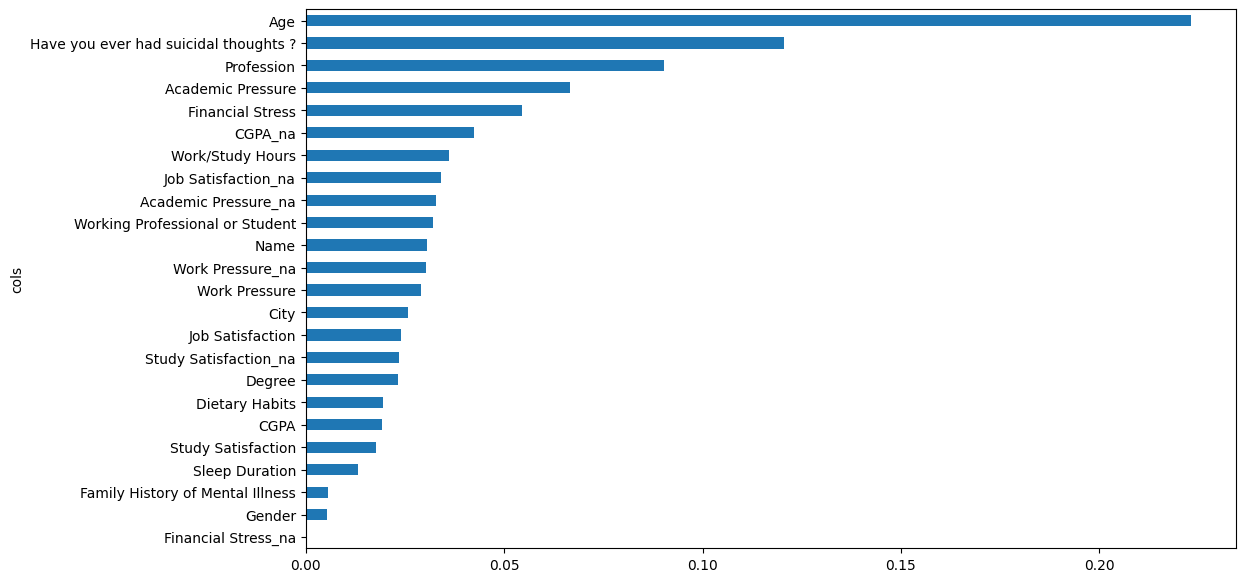

In [69]:
#feature importance visualization
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

#plot_fi(fi[:30]);
plot_fi(fi);

In [70]:
!rm submission.csv
#sub_df['Depression'] = rf_preds
#sub_df.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
#sub

rm: cannot remove 'submission.csv': No such file or directory


## XGBoost

#### Single Fold

In [71]:
%%time
xgb_model = xgb.XGBClassifier()
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

xgb_score = accuracy_score(y_test,xgb_preds_x)
xgb_score

CPU times: user 2.84 s, sys: 54 ms, total: 2.89 s
Wall time: 1.51 s


0.9382373845060412

In [72]:
xgb_oof_preds, xgb_submission_preds, xgb_mean_score, xgb_fold_scores = cross_val_predict(
    model_class=xgb.XGBClassifier
)

Fold 1 AUC: 0.934968
Fold 2 AUC: 0.938033
Fold 3 AUC: 0.937678
Fold 4 AUC: 0.939321
Fold 5 AUC: 0.936079

Mean AUC: 0.937216


In [73]:
xgb_oof_preds

array([0., 0., 0., ..., 0., 1., 0.])

In [74]:
xgb_submission_preds = torch.round(torch.tensor(xgb_submission_preds)).long()
xgb_submission_preds 

tensor([0, 0, 0,  ..., 0, 1, 0])

In [75]:
xgb_mean_score

0.9372157071783939

In [76]:
xgb_fold_scores

[0.9349680170575693,
 0.9380330490405118,
 0.937677683013504,
 0.9393212508884151,
 0.9360785358919688]

In [77]:
xgb_oof_preds.shape, xgb_submission_preds.shape, xgb_mean_score
#fold_scores.shape

((112560,), torch.Size([93800]), 0.9372157071783939)

In [78]:
!rm submission.csv
#sub_df['Depression'] = submission_preds 
#sub_df.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
#sub

rm: cannot remove 'submission.csv': No such file or directory


In [79]:
#%%time
#K_FOLDS = 10  # Number of folds for cross-validation
#skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
#xgb_fold_scores = []

# Array to store out-of-fold predictions
#oof_predictions = np.zeros(len(X_train))

#for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    #X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    #y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    # Train the model on the current fold
    #xgb_model_fold = xgb.XGBClassifier()
    #xgb_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict on the validation set for the current fold
    #y_pred_fold = xgb_model_fold.predict(X_fold_val)
    #y_pred_fold_tt = xgb_model_fold.predict(test_dl.xs)
    
    # Calculate and store the Matthews Correlation Coefficient for the current fold
    #xgb_cv_score = accuracy_score(y_fold_val, y_pred_fold)
    #xgb_fold_scores.append(xgb_cv_score)
    
    #print(f"Fold {fold} AUC: {xgb_cv_score}")

# Calculate and print the mean score across all folds
#xgb_mean_score = np.mean(xgb_fold_scores)
#print(f"Mean AUC: {xgb_mean_score}")

Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

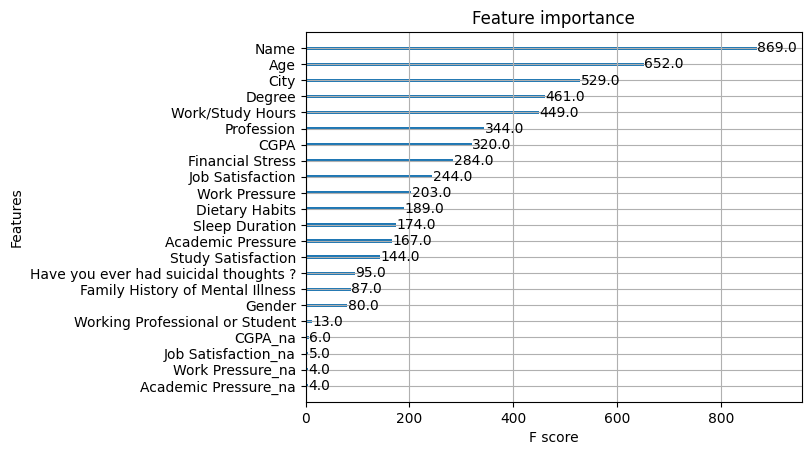

In [80]:
plot_importance(xgb_model)

## LGBM

In [81]:
%%time
#ds subset
lgbm_model = lgb.LGBMClassifier()
lgbm_model = lgbm_model.fit(X_train, y_train)

#test set preds
#lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))
lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))

lgbm_preds_x = tensor(lgbm_model.predict(X_test))

lgbm_score = accuracy_score(y_test,lgbm_preds_x)
lgbm_score

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20413, number of negative: 92147
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 112560, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181352 -> initscore=-1.507213
[LightGBM] [Info] Start training from score -1.507213
CPU times: user 3.07 s, sys: 62 ms, total: 3.14 s
Wall time: 1.66 s


0.939907604832978

In [82]:
lgbm_oof_preds, lgbm_submission_preds, lgbm_mean_score, lgbm_fold_scores = cross_val_predict(
    model_class=lgb.LGBMClassifier
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 16331, number of negative: 73717
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 652
[LightGBM] [Info] Number of data points in the train set: 90048, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181359 -> initscore=-1.507168
[LightGBM] [Info] Start training from score -1.507168
Fold 1 AUC: 0.936834
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 16331, number of negative: 73717
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, 

In [83]:
lgbm_oof_preds

array([0., 0., 0., ..., 0., 1., 0.])

In [84]:
lgbm_submission_preds = torch.round(torch.tensor(lgbm_submission_preds)).long()
lgbm_submission_preds

tensor([0, 0, 0,  ..., 0, 1, 0])

In [85]:
lgbm_mean_score

0.9382729211087419

In [86]:
lgbm_fold_scores

[0.9368336886993603,
 0.937677683013504,
 0.9382107320540156,
 0.9411425017768301,
 0.9375]

In [87]:
lgbm_oof_preds.shape, lgbm_submission_preds.shape, lgbm_mean_score

((112560,), torch.Size([93800]), 0.9382729211087419)

In [88]:
%%time
K_FOLDS = 10
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
lgb_fold_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    lgb_model_fold = lgb.LGBMClassifier()
    lgb_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict on validation set
    y_pred_fold = lgb_model_fold.predict(X_fold_val)
    y_pred_fold_tt = lgb_model_fold.predict(test_dl.xs)
    
    # Calculate accuracy score
    lgb_cv_score = accuracy_score(y_fold_val, lgb_model_fold.predict(X_fold_val))
    lgb_fold_scores.append(lgb_cv_score)
    
    print(f"Fold {fold} AUC: {lgb_cv_score}")

lgb_mean_score = np.mean(lgb_fold_scores)
print(f"Mean AUC: {lgb_mean_score}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 18372, number of negative: 82932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 101304, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181355 -> initscore=-1.507193
[LightGBM] [Info] Start training from score -1.507193
Fold 1 AUC: 0.9344349680170576
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 18372, number of negative: 82932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

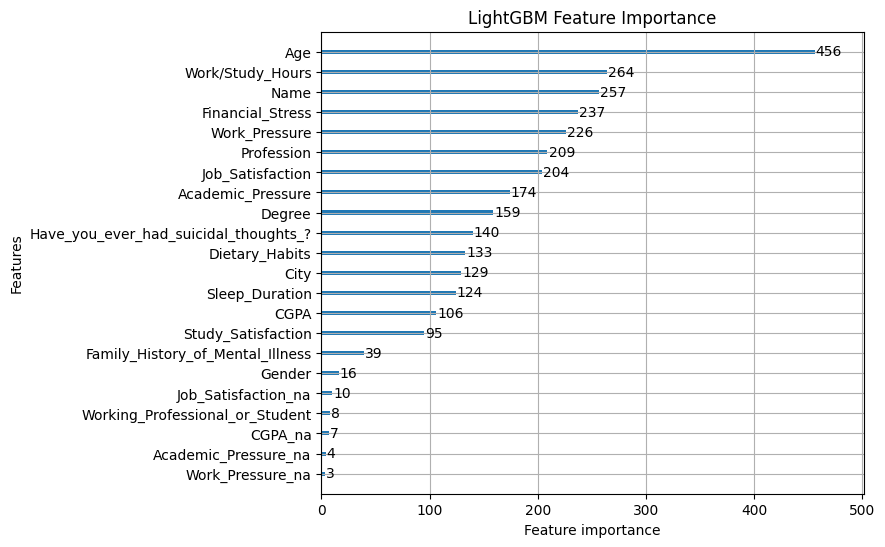

In [89]:
# Plot feature importance without using Gain or split
lgb.plot_importance(lgbm_model, figsize=(7,6), title="LightGBM Feature Importance")
#plt.title('LGBM Feature Importance')
#plt.tight_layout()
plt.show()

## CatBoost

In [90]:
%%time
#using full ds
cat_model_params = CatBoostClassifier(**catboost_params)
cat_model_params = cat_model_params.fit(X_train, y_train, verbose=False)


cat_preds_params = tensor(cat_model_params.predict(test_dl.xs))

cat_preds_x_params = tensor(cat_model_params.predict(X_test))

cat_score_params = accuracy_score(y_test,cat_preds_x_params)
cat_score_params

CPU times: user 51.2 s, sys: 4.87 s, total: 56.1 s
Wall time: 14.6 s


0.9403340440653873

In [91]:
%%time
#using full ds
cat_model = CatBoostClassifier()
cat_model = cat_model.fit(X_train, y_train, verbose=False)


cat_preds = tensor(cat_model.predict(test_dl.xs))

cat_preds_x = tensor(cat_model.predict(X_test))

cat_score = accuracy_score(y_test,cat_preds_x)
cat_score

CPU times: user 1min 3s, sys: 4.62 s, total: 1min 7s
Wall time: 18 s


0.9390191897654584

In [92]:
cat_oof_preds_y, cat_submission_preds_y, cat_mean_score_y, cat_fold_scores_y = cross_val_predict(
    model_class=CatBoostClassifier,
    model_params = catboost_params
)

0:	learn: 0.6047889	total: 18ms	remaining: 12.8s
1:	learn: 0.5335789	total: 35.1ms	remaining: 12.5s
2:	learn: 0.4761849	total: 52ms	remaining: 12.3s
3:	learn: 0.4293171	total: 68.2ms	remaining: 12.1s
4:	learn: 0.3878109	total: 84.1ms	remaining: 11.9s
5:	learn: 0.3550064	total: 99.7ms	remaining: 11.8s
6:	learn: 0.3292610	total: 118ms	remaining: 11.9s
7:	learn: 0.3062518	total: 135ms	remaining: 11.9s
8:	learn: 0.2876418	total: 152ms	remaining: 11.9s
9:	learn: 0.2723091	total: 168ms	remaining: 11.8s
10:	learn: 0.2585680	total: 187ms	remaining: 12s
11:	learn: 0.2494019	total: 205ms	remaining: 12s
12:	learn: 0.2401154	total: 223ms	remaining: 12s
13:	learn: 0.2312563	total: 240ms	remaining: 12s
14:	learn: 0.2246008	total: 258ms	remaining: 12s
15:	learn: 0.2179488	total: 275ms	remaining: 12s
16:	learn: 0.2124815	total: 294ms	remaining: 12.1s
17:	learn: 0.2071837	total: 310ms	remaining: 12s
18:	learn: 0.2027260	total: 329ms	remaining: 12.1s
19:	learn: 0.1988219	total: 347ms	remaining: 12.1s
20

In [93]:
cat_score_params,cat_score

(0.9403340440653873, 0.9390191897654584)

In [94]:
cat_oof_preds, cat_submission_preds, cat_mean_score, cat_fold_scores = cross_val_predict(
    model_class=CatBoostClassifier
)

Learning rate set to 0.070387
0:	learn: 0.5774663	total: 13.8ms	remaining: 13.8s
1:	learn: 0.4933689	total: 27.7ms	remaining: 13.8s
2:	learn: 0.4250063	total: 42ms	remaining: 14s
3:	learn: 0.3753982	total: 56.9ms	remaining: 14.2s
4:	learn: 0.3378702	total: 71.8ms	remaining: 14.3s
5:	learn: 0.3063124	total: 86.5ms	remaining: 14.3s
6:	learn: 0.2813667	total: 101ms	remaining: 14.3s
7:	learn: 0.2649651	total: 116ms	remaining: 14.4s
8:	learn: 0.2490098	total: 131ms	remaining: 14.4s
9:	learn: 0.2364184	total: 146ms	remaining: 14.4s
10:	learn: 0.2261446	total: 160ms	remaining: 14.4s
11:	learn: 0.2179888	total: 174ms	remaining: 14.4s
12:	learn: 0.2117393	total: 188ms	remaining: 14.3s
13:	learn: 0.2058360	total: 204ms	remaining: 14.4s
14:	learn: 0.2008891	total: 219ms	remaining: 14.4s
15:	learn: 0.1962965	total: 234ms	remaining: 14.4s
16:	learn: 0.1939028	total: 248ms	remaining: 14.3s
17:	learn: 0.1909952	total: 263ms	remaining: 14.3s
18:	learn: 0.1875192	total: 277ms	remaining: 14.3s
19:	learn

In [95]:
cat_oof_preds

array([0., 0., 0., ..., 0., 1., 0.])

In [96]:
cat_submission_preds = torch.round(torch.tensor(cat_submission_preds)).long()
cat_submission_preds

tensor([0, 0, 0,  ..., 0, 1, 0])

In [97]:
cat_mean_score,cat_mean_score_y

(0.9387793176972282, 0.9385838663823739)

In [98]:
cat_fold_scores

[0.9367004264392325,
 0.9390103056147833,
 0.9390547263681592,
 0.94136460554371,
 0.9377665245202559]

In [99]:
cat_oof_preds.shape, cat_submission_preds.shape, cat_mean_score

((112560,), torch.Size([93800]), 0.9387793176972282)

In [100]:
%%time
K_FOLDS = 10
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
cat_fold_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    cat_model_fold = CatBoostClassifier()
    cat_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict on validation set
    y_pred_fold = cat_model_fold.predict(X_fold_val)
    y_pred_fold_tt = cat_model_fold.predict(test_dl.xs)
    
    # Calculate accuracy score
    cat_cv_score = accuracy_score(y_fold_val, cat_model_fold.predict(X_fold_val))
    cat_fold_scores.append(cat_cv_score)
    
    print(f"Fold {fold} AUC: {cat_cv_score}")

catboost_mean_score = np.mean(cat_fold_scores)
print(f"Mean AUC: {catboost_mean_score}")

Learning rate set to 0.074018
0:	learn: 0.5723672	total: 16.4ms	remaining: 16.4s
1:	learn: 0.4822500	total: 31.8ms	remaining: 15.9s
2:	learn: 0.4162012	total: 47.5ms	remaining: 15.8s
3:	learn: 0.3642301	total: 63.3ms	remaining: 15.8s
4:	learn: 0.3267928	total: 78.9ms	remaining: 15.7s
5:	learn: 0.2989422	total: 94.1ms	remaining: 15.6s
6:	learn: 0.2747790	total: 110ms	remaining: 15.7s
7:	learn: 0.2567369	total: 126ms	remaining: 15.7s
8:	learn: 0.2418636	total: 143ms	remaining: 15.7s
9:	learn: 0.2299242	total: 159ms	remaining: 15.7s
10:	learn: 0.2206320	total: 174ms	remaining: 15.7s
11:	learn: 0.2130794	total: 191ms	remaining: 15.7s
12:	learn: 0.2073142	total: 207ms	remaining: 15.7s
13:	learn: 0.2013056	total: 223ms	remaining: 15.7s
14:	learn: 0.1967072	total: 239ms	remaining: 15.7s
15:	learn: 0.1940044	total: 254ms	remaining: 15.6s
16:	learn: 0.1909487	total: 269ms	remaining: 15.6s
17:	learn: 0.1880574	total: 285ms	remaining: 15.6s
18:	learn: 0.1848381	total: 301ms	remaining: 15.5s
19:	l

In [101]:
feature_importance = cat_model.get_feature_importance()
feature_names = train_df.columns

# Display feature importance
for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance:.2f}")

Feature: Name, Importance: 4.54
Feature: Gender, Importance: 0.37
Feature: Age, Importance: 2.63
Feature: City, Importance: 0.06
Feature: Working Professional or Student, Importance: 4.84
Feature: Profession, Importance: 2.72
Feature: Academic Pressure, Importance: 2.62
Feature: Work Pressure, Importance: 2.35
Feature: CGPA, Importance: 14.87
Feature: Study Satisfaction, Importance: 0.47
Feature: Job Satisfaction, Importance: 0.76
Feature: Sleep Duration, Importance: 0.04
Feature: Dietary Habits, Importance: 0.88
Feature: Degree, Importance: 0.08
Feature: Have you ever had suicidal thoughts ?, Importance: 0.24
Feature: Work/Study Hours, Importance: 0.00
Feature: Financial Stress, Importance: 28.80
Feature: Family History of Mental Illness, Importance: 3.61
Feature: Depression, Importance: 8.02


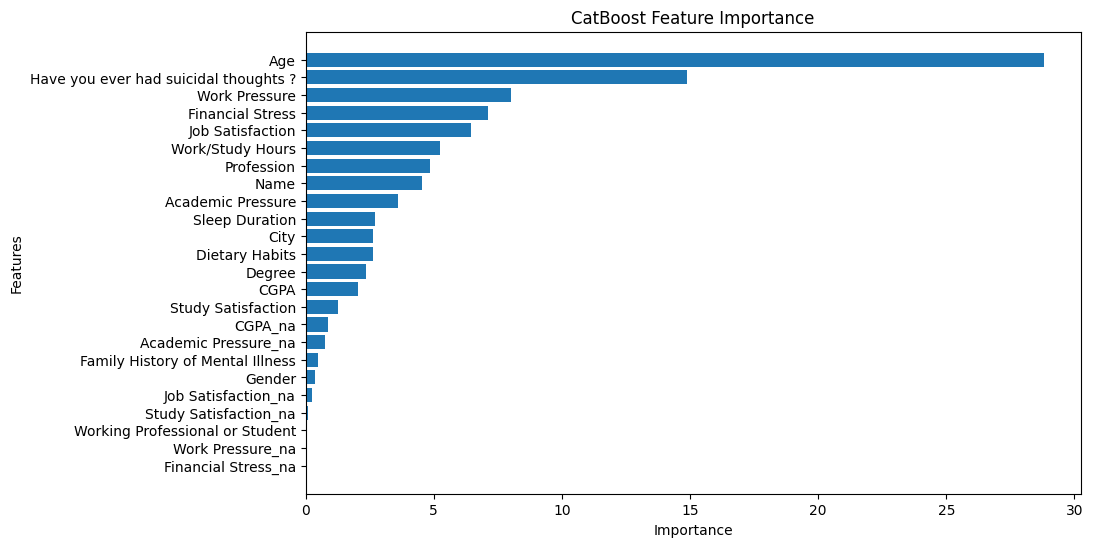

In [102]:
#importances = cat_model.get_feature_importance(type='PredictionValuesChange')
importances = cat_model.get_feature_importance()
feature_importances = pd.Series(importances, index=X_train.columns).sort_values()
plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [103]:
!rm submission.csv
#sub_df['Depression'] = cat_preds
#sub_df.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
#sub

rm: cannot remove 'submission.csv': No such file or directory


# Ensembling

## Averaging

### Scoring

In [104]:
def average_preds_score(preds_a,preds_b):
    average_preds = (torch.round(preds_a + preds_b)/2).long()
    preds_score = accuracy_score(y_test,average_preds)
    print(f"Average_score:{preds_score}")
    return preds_score

In [105]:
xgb_lgbm_score = average_preds_score(xgb_preds_x,lgbm_preds_x)
xgb_lgbm_score

Average_score:0.9384861407249467


0.9384861407249467

In [106]:
cat_lgbm_score = average_preds_score(cat_preds_x,lgbm_preds_x)
cat_lgbm_score

Average_score:0.9389836531627577


0.9389836531627577

In [107]:
cat_xgb_score = average_preds_score(cat_preds_x,xgb_preds_x)
cat_xgb_score

Average_score:0.9380597014925374


0.9380597014925374

In [108]:
cat_rf_score = average_preds_score(cat_preds_x,rf_preds_x)
cat_rf_score

Average_score:0.9374911158493248


0.9374911158493248

In [109]:
lgbm_rf_score = average_preds_score(lgbm_preds_x,rf_preds_x)
lgbm_rf_score

Average_score:0.9381663113006397


0.9381663113006397

In [110]:
xgb_rf_score = average_preds_score(xgb_preds_x,rf_preds_x)
xgb_rf_score

Average_score:0.9372068230277185


0.9372068230277185

In [111]:
cat_xgb_lgbm_preds_x = (cat_preds_x + xgb_preds_x + lgbm_preds_x)/3
cat_xgb_lgbm_preds_x = torch.round(cat_xgb_lgbm_preds_x).long()
cat_xgb_lgbm_score = accuracy_score(y_test,cat_xgb_lgbm_preds_x)

In [112]:
cat_xgb_lgbm_rf_preds_x = (cat_preds_x + xgb_preds_x + lgbm_preds_x + rf_preds_x)/4
cat_xgb_lgbm_rf_preds_x = torch.round(cat_xgb_lgbm_rf_preds_x).long()
cat_xgb_lgbm_rf_score = accuracy_score(y_test,cat_xgb_lgbm_rf_preds_x)

## Submission

In [113]:
def average_preds_sub(preds_a,preds_b):
    average_preds_sub = (torch.round(preds_a + preds_b)/2).long()
    return average_preds_sub

In [114]:
cat_lgbm_preds = average_preds_sub(cat_preds,lgbm_preds)
cat_lgbm_preds

tensor([0, 0, 0,  ..., 0, 1, 0])

In [115]:
cat_xgb_preds = average_preds_sub(cat_preds,xgb_preds)
cat_xgb_preds

tensor([0, 0, 0,  ..., 0, 1, 0])

In [116]:
xgb_lgbm_preds = average_preds_sub(xgb_preds,lgbm_preds)
xgb_lgbm_preds

tensor([0, 0, 0,  ..., 0, 1, 0])

In [117]:
cat_xgb_lgbm_preds = (cat_preds + xgb_preds + lgbm_preds)/3
cat_xgb_lgbm_preds = torch.round(cat_xgb_lgbm_preds).long()
cat_xgb_lgbm_preds

tensor([0, 0, 0,  ..., 0, 1, 0])

In [118]:
cat_xgb_lgbm_rf_preds = (cat_preds + xgb_preds + lgbm_preds + rf_preds)/4
cat_xgb_lgbm_rf_preds = torch.round(cat_xgb_lgbm_rf_preds).long()
cat_xgb_lgbm_rf_preds

tensor([0, 0, 0,  ..., 0, 1, 0])

In [119]:
#!rm submission.csv
#sub_df['Depression'] = cat_xgb_lgbm_rf_preds
#sub_df.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
#sub

## Hill Climbing

Below, i try to create a weighted ensemble using hill climbing, first i shall try for lgbm and catboost which are my best performing models so far

In [120]:
# Get class predictions for only CatBoost and LightGBM
lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))
cat_preds = tensor(cat_model.predict(test_dl.xs))

# Validation predictions
lgbm_valid_preds = tensor(lgbm_model.predict(X_test))
cat_valid_preds = tensor(cat_model.predict(X_test))

# Create validation DataFrame for hill climbing
valid_ensemble = pd.DataFrame({
    'lgbm': lgbm_valid_preds,
    'cat': cat_valid_preds
})

# Create test DataFrame for hill climbing
test_ensemble = pd.DataFrame({
    'lgbm': lgbm_preds,
    'cat': cat_preds
})

def climb_hill(train_preds, test_preds, y_true, precision=0.001, max_iter=1000):
    n_models = train_preds.shape[1]
    weights = np.ones(n_models) / n_models  # Start with equal weights
    
    # For class predictions, round the weighted sum
    best_preds = np.round(train_preds @ weights).astype(int)
    best_score = accuracy_score(y_true, best_preds)
    improved = True
    iter_count = 0
    
    while improved and iter_count < max_iter:
        improved = False
        iter_count += 1
        
        for i in range(n_models):
            # Try increasing weight
            new_weights = weights.copy()
            new_weights[i] += precision
            new_weights = new_weights / new_weights.sum()  # Normalize
            
            new_preds = np.round(train_preds @ new_weights).astype(int)
            new_score = accuracy_score(y_true, new_preds)
            
            if new_score > best_score:
                weights = new_weights
                best_score = new_score
                improved = True
                continue
                
            # Try decreasing weight
            new_weights = weights.copy()
            new_weights[i] = max(0, new_weights[i] - precision)
            new_weights = new_weights / new_weights.sum()  # Normalize
            
            new_preds = np.round(train_preds @ new_weights).astype(int)
            new_score = accuracy_score(y_true, new_preds)
            
            if new_score > best_score:
                weights = new_weights
                best_score = new_score
                improved = True
    
    # Get final predictions for both validation and test
    valid_preds = np.round(train_preds @ weights).astype(int)
    test_preds = np.round(test_preds @ weights).astype(int)
    
    return valid_preds, test_preds, weights, best_score

# Apply hill climbing
valid_preds, optimized_test_preds, final_weights, best_score = climb_hill(
    valid_ensemble.values, 
    test_ensemble.values, 
    y_test
)

print(f"Optimized weights: {final_weights}")
print(f"Best validation accuracy: {best_score}")

# Compare scores
print("\nModel Scores:")
print(f"LightGBM: {lgbm_score}")
print(f"CatBoost: {cat_score}")
print(f"Hill Climbing Ensemble: {best_score}")

# Create submission with optimized predictions
sub_df['Depression'] = optimized_test_preds
sub_df.to_csv('submission.csv', index=False)

Optimized weights: [0.5004995 0.4995005]
Best validation accuracy: 0.939907604832978

Model Scores:
LightGBM: 0.939907604832978
CatBoost: 0.9390191897654584
Hill Climbing Ensemble: 0.939907604832978


Hill climbing and catboost score seem to be the same, did it just selcet cat scores ?

add something to show model contribution percentage

In [121]:
# Get class predictions for only CatBoost and LightGBM
lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))
cat_preds = tensor(cat_model.predict(test_dl.xs))

# Validation predictions
lgbm_valid_preds = tensor(lgbm_model.predict(X_test))
cat_valid_preds = tensor(cat_model.predict(X_test))

# Create validation DataFrame for hill climbing
valid_ensemble = pd.DataFrame({
    'lgbm': lgbm_valid_preds,
    'cat': cat_valid_preds
})

# Create test DataFrame for hill climbing
test_ensemble = pd.DataFrame({
    'lgbm': lgbm_preds,
    'cat': cat_preds
})

def climb_hill(train_preds, test_preds, y_true, precision=0.001, max_iter=1000):
    n_models = train_preds.shape[1]
    weights = np.ones(n_models) / n_models  # Start with equal weights
    
    best_preds = np.round(train_preds @ weights).astype(int)
    best_score = accuracy_score(y_true, best_preds)
    improved = True
    iter_count = 0
    
    while improved and iter_count < max_iter:
        improved = False
        iter_count += 1
        
        for i in range(n_models):
            # Try increasing weight
            new_weights = weights.copy()
            new_weights[i] += precision
            new_weights = new_weights / new_weights.sum()  # Normalize
            
            new_preds = np.round(train_preds @ new_weights).astype(int)
            new_score = accuracy_score(y_true, new_preds)
            
            if new_score > best_score:
                weights = new_weights
                best_score = new_score
                improved = True
                continue
                
            # Try decreasing weight
            new_weights = weights.copy()
            new_weights[i] = max(0, new_weights[i] - precision)
            new_weights = new_weights / new_weights.sum()  # Normalize
            
            new_preds = np.round(train_preds @ new_weights).astype(int)
            new_score = accuracy_score(y_true, new_preds)
            
            if new_score > best_score:
                weights = new_weights
                best_score = new_score
                improved = True
    
    # Get final predictions for both validation and test
    valid_preds = np.round(train_preds @ weights).astype(int)
    test_preds = np.round(test_preds @ weights).astype(int)
    
    # Calculate percentage contributions
    percentages = {
        'LightGBM': weights[0] * 100,
        'CatBoost': weights[1] * 100
    }
    
    return valid_preds, test_preds, weights, best_score, percentages

# Apply hill climbing
valid_preds, optimized_test_preds, final_weights, best_score, model_percentages = climb_hill(
    valid_ensemble.values, 
    test_ensemble.values, 
    y_test
)

print("\nModel Contributions:")
for model, percentage in model_percentages.items():
    print(f"{model}: {percentage:.2f}%")

print(f"\nBest validation accuracy: {best_score}")

# Compare scores
print("\nIndividual Model Scores:")
print(f"LightGBM: {lgbm_score}")
print(f"CatBoost: {cat_score}")
print(f"Hill Climbing Ensemble: {best_score}")

# Create submission with optimized predictions
sub_df['Depression'] = optimized_test_preds
sub_df.to_csv('submission.csv', index=False)


Model Contributions:
LightGBM: 50.05%
CatBoost: 49.95%

Best validation accuracy: 0.939907604832978

Individual Model Scores:
LightGBM: 0.939907604832978
CatBoost: 0.9390191897654584
Hill Climbing Ensemble: 0.939907604832978


xgb + lgbm + cat

In [122]:
# Get both probabilities and class predictions
xgb_preds = tensor(xgb_model.predict(test_dl.xs))
lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))
cat_preds = tensor(cat_model.predict(test_dl.xs))

# Validation predictions
xgb_valid_preds = tensor(xgb_model.predict(X_test))
lgbm_valid_preds = tensor(lgbm_model.predict(X_test))
cat_valid_preds = tensor(cat_model.predict(X_test))

# Create validation DataFrame for hill climbing
valid_ensemble = pd.DataFrame({
    'xgb': xgb_valid_preds,
    'lgbm': lgbm_valid_preds,
    'cat': cat_valid_preds
})

# Create test DataFrame for hill climbing
test_ensemble = pd.DataFrame({
    'xgb': xgb_preds,
    'lgbm': lgbm_preds,
    'cat': cat_preds
})

def climb_hill(train_preds, test_preds, y_true, precision=0.001, max_iter=1000):
    n_models = train_preds.shape[1]
    weights = np.ones(n_models) / n_models  # Start with equal weights
    
    # For class predictions, round the weighted sum
    best_preds = np.round(train_preds @ weights).astype(int)
    best_score = accuracy_score(y_true, best_preds)
    improved = True
    iter_count = 0
    
    while improved and iter_count < max_iter:
        improved = False
        iter_count += 1
        
        for i in range(n_models):
            # Try increasing weight
            new_weights = weights.copy()
            new_weights[i] += precision
            new_weights = new_weights / new_weights.sum()  # Normalize
            
            new_preds = np.round(train_preds @ new_weights).astype(int)
            new_score = accuracy_score(y_true, new_preds)
            
            if new_score > best_score:
                weights = new_weights
                best_score = new_score
                improved = True
                continue
                
            # Try decreasing weight
            new_weights = weights.copy()
            new_weights[i] = max(0, new_weights[i] - precision)
            new_weights = new_weights / new_weights.sum()  # Normalize
            
            new_preds = np.round(train_preds @ new_weights).astype(int)
            new_score = accuracy_score(y_true, new_preds)
            
            if new_score > best_score:
                weights = new_weights
                best_score = new_score
                improved = True
    
    # Get final predictions for both validation and test
    valid_preds = np.round(train_preds @ weights).astype(int)
    test_preds = np.round(test_preds @ weights).astype(int)
    
    return valid_preds, test_preds, weights, best_score

# Apply hill climbing
valid_preds, optimized_test_preds, final_weights, best_score = climb_hill(
    valid_ensemble.values, 
    test_ensemble.values, 
    y_test
)

print(f"Optimized weights: {final_weights}")
print(f"Best validation accuracy: {best_score}")

# Compare scores
print("\nModel Scores:")
print(f"XGBoost: {xgb_score}")
print(f"LightGBM: {lgbm_score}")
print(f"CatBoost: {cat_score}")
print(f"Hill Climbing Ensemble: {best_score}")

# Create submission with optimized predictions
sub_df['Depression'] = optimized_test_preds
sub_df.to_csv('submission.csv', index=False)

Optimized weights: [0.33333333 0.33333333 0.33333333]
Best validation accuracy: 0.9394811656005686

Model Scores:
XGBoost: 0.9382373845060412
LightGBM: 0.939907604832978
CatBoost: 0.9390191897654584
Hill Climbing Ensemble: 0.9394811656005686


In [123]:
sub = pd.read_csv('submission.csv')
sub

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0
...,...,...
93795,234495,0
93796,234496,1
93797,234497,0
93798,234498,1


## Stacking

In [124]:
stacking_estimators = [
    ('cat_boost',cat_model),
    #('rf',rf_model),
    ('lgbm',lgbm_model),
    ('xgb',xgb_model),
]

stacking_classifier_cat_xgb_lgbm= StackingClassifier(
    estimators=stacking_estimators,
    final_estimator=LogisticRegression(),
    cv=5
)
#stacking_classifier_cat_lgbm= StackingClassifier(
    #estimators=stacking_estimators,
    #final_estimator=lgb.LGBMClassifier(**lgbm_params),
    #cv=5
#)
stacking_classifier_cat_xgb_lgbm.fit(X_train, y_train)


stacking_preds_cat_xgb_lgbm = (stacking_classifier_cat_xgb_lgbm.predict(test_dl.xs))
stacking_preds_cat_xgb_lgbm_x = stacking_classifier_cat_xgb_lgbm.predict(X_test)

stacking_score_cat_xgb_lgbm = accuracy_score(y_test, stacking_preds_cat_xgb_lgbm_x)

print(f"Final Stacking Classifier Accuracy on test set: {stacking_score_cat_xgb_lgbm}")

Learning rate set to 0.077424
0:	learn: 0.5693091	total: 19.1ms	remaining: 19.1s
1:	learn: 0.4780881	total: 36.2ms	remaining: 18.1s
2:	learn: 0.4094254	total: 53.7ms	remaining: 17.8s
3:	learn: 0.3554333	total: 70.6ms	remaining: 17.6s
4:	learn: 0.3177354	total: 87.3ms	remaining: 17.4s
5:	learn: 0.2885916	total: 105ms	remaining: 17.4s
6:	learn: 0.2668088	total: 121ms	remaining: 17.2s
7:	learn: 0.2494842	total: 139ms	remaining: 17.2s
8:	learn: 0.2359453	total: 156ms	remaining: 17.2s
9:	learn: 0.2252533	total: 173ms	remaining: 17.1s
10:	learn: 0.2161684	total: 193ms	remaining: 17.4s
11:	learn: 0.2098412	total: 211ms	remaining: 17.4s
12:	learn: 0.2034784	total: 228ms	remaining: 17.3s
13:	learn: 0.1989937	total: 246ms	remaining: 17.3s
14:	learn: 0.1940751	total: 264ms	remaining: 17.3s
15:	learn: 0.1907556	total: 281ms	remaining: 17.3s
16:	learn: 0.1884764	total: 297ms	remaining: 17.2s
17:	learn: 0.1866726	total: 313ms	remaining: 17.1s
18:	learn: 0.1840768	total: 330ms	remaining: 17s
19:	lear

In [125]:
stacking_preds_cat_xgb_lgbm.shape

(93800,)

In [126]:
stacking_preds_cat_xgb_lgbm = torch.tensor(stacking_preds_cat_xgb_lgbm)

In [127]:
stacking_estimators = [
    ('cat_boost',cat_model),
    ('rf',rf_model),
    ('lgbm',lgbm_model),
    ('xgb',xgb_model),
]

stacking_classifier_cat_xgb_lgbm_rf= StackingClassifier(
    estimators=stacking_estimators,
    final_estimator=LogisticRegression(),
    cv=5
)
#stacking_classifier_cat_lgbm= StackingClassifier(
    #estimators=stacking_estimators,
    #final_estimator=lgb.LGBMClassifier(**lgbm_params),
    #cv=5
#)
stacking_classifier_cat_xgb_lgbm_rf.fit(X_train, y_train)


stacking_preds_cat_xgb_lgbm_rf = (stacking_classifier_cat_xgb_lgbm_rf.predict(test_dl.xs))
stacking_preds_cat_xgb_lgbm_rf_x = stacking_classifier_cat_xgb_lgbm_rf.predict(X_test)

stacking_score_cat_xgb_lgbm_rf = accuracy_score(y_test, stacking_preds_cat_xgb_lgbm_rf_x)

print(f"Final Stacking Classifier Accuracy on test set: {stacking_score_cat_xgb_lgbm_rf}")

Learning rate set to 0.077424
0:	learn: 0.5693091	total: 29.5ms	remaining: 29.4s
1:	learn: 0.4780881	total: 56.3ms	remaining: 28.1s
2:	learn: 0.4094254	total: 73.8ms	remaining: 24.5s
3:	learn: 0.3554333	total: 93.1ms	remaining: 23.2s
4:	learn: 0.3177354	total: 110ms	remaining: 21.9s
5:	learn: 0.2885916	total: 128ms	remaining: 21.1s
6:	learn: 0.2668088	total: 144ms	remaining: 20.5s
7:	learn: 0.2494842	total: 163ms	remaining: 20.2s
8:	learn: 0.2359453	total: 180ms	remaining: 19.8s
9:	learn: 0.2252533	total: 197ms	remaining: 19.5s
10:	learn: 0.2161684	total: 217ms	remaining: 19.5s
11:	learn: 0.2098412	total: 237ms	remaining: 19.5s
12:	learn: 0.2034784	total: 257ms	remaining: 19.5s
13:	learn: 0.1989937	total: 275ms	remaining: 19.4s
14:	learn: 0.1940751	total: 294ms	remaining: 19.3s
15:	learn: 0.1907556	total: 310ms	remaining: 19.1s
16:	learn: 0.1884764	total: 327ms	remaining: 18.9s
17:	learn: 0.1866726	total: 350ms	remaining: 19.1s
18:	learn: 0.1840768	total: 370ms	remaining: 19.1s
19:	lea

In [128]:
stacking_estimators = [
    ('cat_boost',cat_model),
    #('rf',rf_model),
    ('lgbm',lgbm_model),
    #('xgb',xgb_model),
]

stacking_classifier_cat_lgbm= StackingClassifier(
    estimators=stacking_estimators,
    final_estimator=LogisticRegression(),
    cv=5
)
#stacking_classifier_cat_lgbm= StackingClassifier(
    #estimators=stacking_estimators,
    #final_estimator=lgb.LGBMClassifier(**lgbm_params),
    #cv=5
#)
stacking_classifier_cat_lgbm.fit(X_train, y_train)


stacking_preds_cat_lgbm = (stacking_classifier_cat_lgbm.predict(test_dl.xs))
stacking_preds_cat_lgbm_x = stacking_classifier_cat_lgbm.predict(X_test)

stacking_score_cat_lgbm = accuracy_score(y_test, stacking_preds_cat_lgbm_x)

print(f"Final Stacking Classifier Accuracy on test set: {stacking_score_cat_lgbm}")

Learning rate set to 0.077424
0:	learn: 0.5693091	total: 17.7ms	remaining: 17.7s
1:	learn: 0.4780881	total: 36ms	remaining: 18s
2:	learn: 0.4094254	total: 54.3ms	remaining: 18s
3:	learn: 0.3554333	total: 71.4ms	remaining: 17.8s
4:	learn: 0.3177354	total: 87.9ms	remaining: 17.5s
5:	learn: 0.2885916	total: 105ms	remaining: 17.4s
6:	learn: 0.2668088	total: 121ms	remaining: 17.2s
7:	learn: 0.2494842	total: 139ms	remaining: 17.2s
8:	learn: 0.2359453	total: 156ms	remaining: 17.2s
9:	learn: 0.2252533	total: 173ms	remaining: 17.1s
10:	learn: 0.2161684	total: 192ms	remaining: 17.3s
11:	learn: 0.2098412	total: 210ms	remaining: 17.3s
12:	learn: 0.2034784	total: 227ms	remaining: 17.2s
13:	learn: 0.1989937	total: 243ms	remaining: 17.1s
14:	learn: 0.1940751	total: 260ms	remaining: 17.1s
15:	learn: 0.1907556	total: 276ms	remaining: 17s
16:	learn: 0.1884764	total: 292ms	remaining: 16.9s
17:	learn: 0.1866726	total: 308ms	remaining: 16.8s
18:	learn: 0.1840768	total: 325ms	remaining: 16.8s
19:	learn: 0.1

In [129]:
stacking_score_cat_xgb_lgbm,stacking_score_cat_xgb_lgbm_rf,stacking_score_cat_lgbm

(0.9397654584221748, 0.9392679459843639, 0.9396588486140725)

In [130]:
#!rm submission.csv
#sub_df['Depression'] = stacking_preds_cat_xgb_lgbm
#sub_df.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
#sub

In the next version ill try out voting and compare performance

### Voting

In [131]:
%%time
# Assuming rf_model,xgb_model etc. *are already fitted models
# Wrap them in a VotingClassifier
voting_clf = VotingClassifier(estimators=[
    #('rf', rf_model),  
    ('xgb', xgb_model),  
    ('cat', cat_model),  
    ('lgb', lgbm_model)
    #('nn', nn_model)
], voting='soft')



voting_clf.fit(X_train, y_train)

voting_predictions = voting_clf.predict(test_dl.xs)
voting_predictions_x = voting_clf.predict(X_test)

# Calculate the accuracy score
voting_accuracy_soft = accuracy_score(y_test, voting_predictions_x)
#print(f"Accuracy: {voting_accuracy:.6f}")

Learning rate set to 0.077424
0:	learn: 0.5693091	total: 17.4ms	remaining: 17.4s
1:	learn: 0.4780881	total: 33.8ms	remaining: 16.9s
2:	learn: 0.4094254	total: 50.8ms	remaining: 16.9s
3:	learn: 0.3554333	total: 67.8ms	remaining: 16.9s
4:	learn: 0.3177354	total: 84.4ms	remaining: 16.8s
5:	learn: 0.2885916	total: 102ms	remaining: 16.9s
6:	learn: 0.2668088	total: 118ms	remaining: 16.8s
7:	learn: 0.2494842	total: 136ms	remaining: 16.9s
8:	learn: 0.2359453	total: 153ms	remaining: 16.8s
9:	learn: 0.2252533	total: 169ms	remaining: 16.8s
10:	learn: 0.2161684	total: 188ms	remaining: 16.9s
11:	learn: 0.2098412	total: 206ms	remaining: 16.9s
12:	learn: 0.2034784	total: 222ms	remaining: 16.9s
13:	learn: 0.1989937	total: 239ms	remaining: 16.8s
14:	learn: 0.1940751	total: 256ms	remaining: 16.8s
15:	learn: 0.1907556	total: 272ms	remaining: 16.7s
16:	learn: 0.1884764	total: 288ms	remaining: 16.6s
17:	learn: 0.1866726	total: 304ms	remaining: 16.6s
18:	learn: 0.1840768	total: 321ms	remaining: 16.6s
19:	le

In [132]:
voting_accuracy_soft

0.939729921819474

In [133]:
voting_predictions.shape

(93800,)

In [134]:
voting_predictions = torch.tensor(voting_predictions)

I also try with voting = hard

In [135]:
%%time
# Assuming rf_model,xgb_model etc. *are already fitted models
# Wrap them in a VotingClassifier
voting_clf_hard = VotingClassifier(estimators=[
    #('rf', rf_model),  
    ('xgb', xgb_model),  
    ('cat', cat_model),  
    ('lgb', lgbm_model)
    #('nn', nn_model)
], voting='hard')



voting_clf_hard.fit(X_train, y_train)

voting_predictions_hard = voting_clf_hard.predict(test_dl.xs)
voting_predictions_hard_x = voting_clf_hard.predict(X_test)

# Calculate the accuracy score
voting_accuracy_hard = accuracy_score(y_test, voting_predictions_hard_x)
print(f"Accuracy: {voting_accuracy_hard:.6f}")

Learning rate set to 0.077424
0:	learn: 0.5693091	total: 18.6ms	remaining: 18.6s
1:	learn: 0.4780881	total: 35ms	remaining: 17.5s
2:	learn: 0.4094254	total: 52.2ms	remaining: 17.3s
3:	learn: 0.3554333	total: 69.1ms	remaining: 17.2s
4:	learn: 0.3177354	total: 86ms	remaining: 17.1s
5:	learn: 0.2885916	total: 103ms	remaining: 17.1s
6:	learn: 0.2668088	total: 120ms	remaining: 17s
7:	learn: 0.2494842	total: 137ms	remaining: 17s
8:	learn: 0.2359453	total: 154ms	remaining: 16.9s
9:	learn: 0.2252533	total: 170ms	remaining: 16.9s
10:	learn: 0.2161684	total: 189ms	remaining: 16.9s
11:	learn: 0.2098412	total: 206ms	remaining: 17s
12:	learn: 0.2034784	total: 223ms	remaining: 17s
13:	learn: 0.1989937	total: 240ms	remaining: 16.9s
14:	learn: 0.1940751	total: 257ms	remaining: 16.9s
15:	learn: 0.1907556	total: 273ms	remaining: 16.8s
16:	learn: 0.1884764	total: 289ms	remaining: 16.7s
17:	learn: 0.1866726	total: 305ms	remaining: 16.6s
18:	learn: 0.1840768	total: 322ms	remaining: 16.6s
19:	learn: 0.18181

# Final Submission

In [136]:
!rm submission.csv
sub_df['Depression'] = cat_preds
sub_df.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
sub

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0
...,...,...
93795,234495,0
93796,234496,1
93797,234497,0
93798,234498,1


## Ranking performance

In [137]:
accuracy = pd.DataFrame({
    'algorithm': [ 'XGBoost','XGBoost CV','LGBM','LGBM CV',
                  'CatBoost','CatBoost CV','Random Forest',
                  'RF CV','XGB + LGBM', 'CAT + LGBM',
                  'CAT + XGB', 'CAT + XGB + LGBM',
                  'CAT + XGB + LGBM + RF','CAT + RF',
                  'LGBM + RF','XGB + RF','Hill Climbing CAT+LGBM',
                  'Stacking cat+xgb+lgbm','Stacking cat+xgb+lgb+rf',
                  'Stacking Cat+Lgbm','Voting Soft','Voting Hard'
                 ],
    'accuracy': [xgb_score,xgb_mean_score,lgbm_score,
                 lgbm_mean_score,cat_score,cat_mean_score,rf_score,
                 rf_mean_score,xgb_lgbm_score,cat_lgbm_score,
                 cat_xgb_score,cat_xgb_lgbm_score,
                 cat_xgb_lgbm_rf_score,cat_rf_score,
                 lgbm_rf_score,xgb_rf_score,best_score,
                 stacking_score_cat_xgb_lgbm,stacking_score_cat_xgb_lgbm_rf,
                 stacking_score_cat_lgbm,voting_accuracy_soft,
                 voting_accuracy_hard
           ]
})

accuracy_sorted = accuracy.sort_values(by='accuracy', ascending=False)
accuracy_sorted

,algorithm,accuracy
2,LGBM,0.939908
17,Stacking cat+xgb+lgbm,0.939765
20,Voting Soft,0.939730
19,Stacking Cat+Lgbm,0.939659
11,CAT + XGB + LGBM,0.939481
16,Hill Climbing CAT+LGBM,0.939481
21,Voting Hard,0.939481
18,Stacking cat+xgb+lgb+rf,0.939268
12,CAT + XGB + LGBM + RF,0.939161
4,CatBoost,0.939019


In [138]:
cat_score_params,cat_score,cat_mean_score,cat_mean_score_y

(0.9403340440653873,
 0.9390191897654584,
 0.9387793176972282,
 0.9385838663823739)

# Conclusions

CatBoost so far seems to out perform other models


Version 50 - trying new cat params

In [139]:
cat_score_params,cat_score,cat_mean_score,cat_mean_score_y

(0.9403340440653873,
 0.9390191897654584,
 0.9387793176972282,
 0.9385838663823739)

In [140]:
accuracy = pd.DataFrame({
    'algorithm': ['CatBoost','CatBoost Optuna','CatBoost CV','CatBoost CV Optuna'
                 ],
    'accuracy': [cat_score,cat_score_params,cat_mean_score,cat_mean_score_y
           ]
})

accuracy_sorted = accuracy.sort_values(by='accuracy', ascending=False)
accuracy_sorted

,algorithm,accuracy
1,CatBoost Optuna,0.940334
0,CatBoost,0.939019
2,CatBoost CV,0.938779
3,CatBoost CV Optuna,0.938584
